## LHS + Gradient-based / Bayesian Opt.

Initial guess for optimization (from LHS): [-207.22106874  317.34503499], Function value: -40.01320889969688


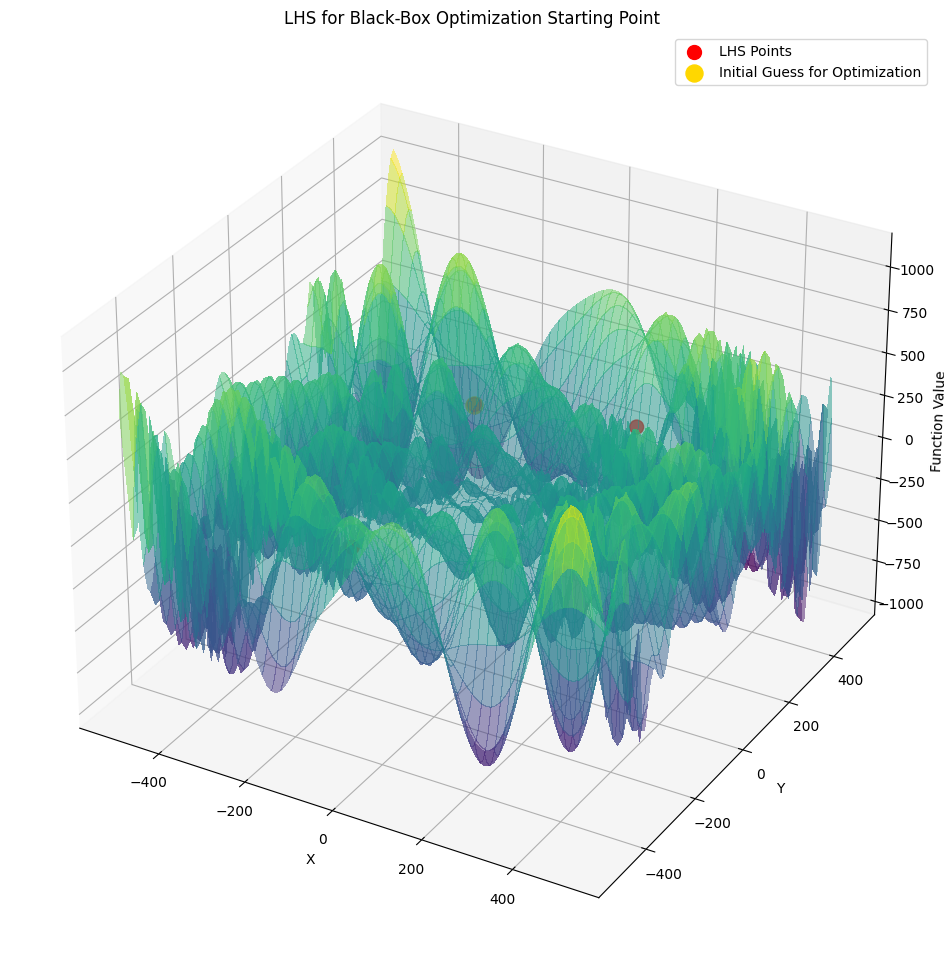

In [ ]:
import numpy as np
from scipy.stats import qmc
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Define the Eggholder function
def eggholder_function(x, y):
    term1 = -(y + 47) * np.sin(np.sqrt(abs(x/2 + (y + 47))))
    term2 = -x * np.sin(np.sqrt(abs(x - (y + 47))))
    return term1 + term2

# Initialize Latin Hypercube Sampler for 2D parameter space
sampler = qmc.LatinHypercube(d=2, seed=1)
num_samples = 5
samples = sampler.random(n=num_samples)

# Scale the LHS samples to the Eggholder function's domain
lower_bounds = np.array([-512, -512])
upper_bounds = np.array([512, 512])
scaled_samples = qmc.scale(samples, lower_bounds, upper_bounds)

# Evaluate the Eggholder function at the LHS points
function_values = np.array([eggholder_function(x, y) for x, y in scaled_samples])

# Identify the point with the minimum function value for potential optimization starting point
min_index = np.argmin(function_values)
min_point = scaled_samples[min_index]
min_value = function_values[min_index]

print(f"Initial guess for optimization (from LHS): {min_point}, Function value: {min_value}")

# Plotting for visualization
fig = plt.figure(figsize=(15,12))
ax = fig.add_subplot(111, projection='3d')
x = np.linspace(-512, 512, 100)
y = np.linspace(-512, 512, 100)
X, Y = np.meshgrid(x, y)
Z = eggholder_function(X, Y)
ax.plot_surface(X, Y, Z, cmap='viridis', alpha=0.5, linewidth=0, antialiased=False)
ax.scatter(scaled_samples[:, 0], scaled_samples[:, 1], function_values, color='r', s=100, label='LHS Points')
ax.scatter(min_point[0], min_point[1], min_value, color='gold', s=150, label='Initial Guess for Optimization')
ax.set_title('LHS for Black-Box Optimization Starting Point')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Function Value')
ax.legend()
plt.show()


#### Gradient-based

In [ ]:
import numpy as np

# Numerical gradient approximation
def approximate_gradient(f, x, y, h=1e-5):
    grad_x = (f(x + h, y) - f(x - h, y)) / (2 * h)
    grad_y = (f(x, y + h) - f(x, y - h)) / (2 * h)
    return np.array([grad_x, grad_y])

# Gradient descent update
def gradient_descent_step(f, x, y, learning_rate=0.001):
    gradient = approximate_gradient(f, x, y)
    new_x = x - learning_rate * gradient[0]
    new_y = y - learning_rate * gradient[1]
    return new_x, new_y

# Initialize from the LHS point with the minimum function value
# Assuming 'min_point' from the previous code snippet
x_init, y_init = min_point

# Gradient descent iterations
num_iterations = 100
x_current, y_current = x_init, y_init
for i in range(num_iterations):
    x_next, y_next = gradient_descent_step(eggholder_function, x_current, y_current)
    if np.sqrt((x_next - x_current)**2 + (y_next - y_current)**2) < 1e-6:  # Convergence check
        break
    x_current, y_current = x_next, y_next

final_value = eggholder_function(x_current, y_current)
print(f"Optimized location: ({x_current}, {y_current}), Function value: {final_value}")

# Note: The actual performance and convergence to a global minimum cannot be guaranteed
# due to the complex landscape of the Eggholder function. This example is for illustrative purposes.


Optimized location: (-207.68715581703327, 316.12963912962516), Function value: -56.958740617093724


#### Bayesian Optimization

In [ ]:
!pip install scikit-optimize

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.7/107.7 kB 600.7 kB/s eta 0:00:00


Optimal location: [-470.48406209833956, 386.0383489092959], Function value: -891.6799465681602


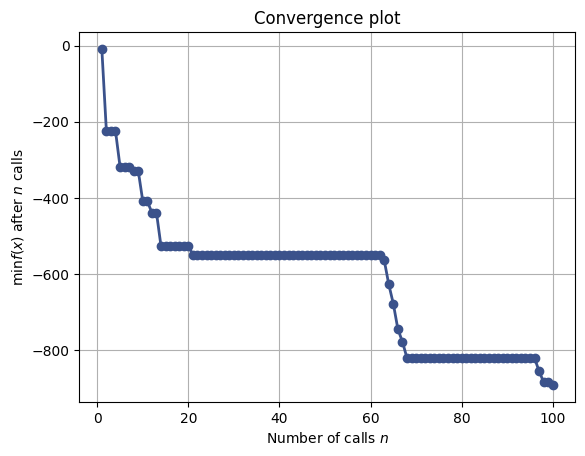

In [ ]:
import numpy as np
from skopt import gp_minimize
from skopt.space import Real
from skopt.plots import plot_convergence
import matplotlib.pyplot as plt

# Define the Eggholder function
def eggholder_function(X):
    x, y = X
    return -(y + 47) * np.sin(np.sqrt(abs(x/2 + (y + 47)))) - x * np.sin(np.sqrt(abs(x - (y + 47))))

# Define the search space
space  = [Real(-512, 512, name='x'), Real(-512, 512, name='y')]

# Perform Bayesian Optimization
result = gp_minimize(eggholder_function,              # the function to minimize
                      space,                          # the bounds on each dimension of x
                      acq_func="EI",                  # the acquisition function
                      n_calls=100,                    # the number of evaluations of f
                      n_random_starts=5,              # the number of random initialization points
                      noise=0.1**2,                   # the noise level (optional)
                      random_state=1729)              # the random seed

# Results
print(f"Optimal location: {result.x}, Function value: {result.fun}")

# Plot convergence
plot_convergence(result)
plt.show()


## First Trial

For black-box optimization (BBO) using Bayesian optimization and starting with 5 samples generated by Latin Hypercube Sampling (LHS), we can use a library such as scikit-optimize which implements Bayesian optimization using Gaussian Processes.

The process aligns with the schema you've provided:

1. Initial Sample: Generate initial samples using LHS.
2. Learner: Use a surrogate model (Gaussian Process) to learn from the samples.
3. Oracle: The Eggholder function serves as the oracle, providing true evaluations of the samples.
4. Adaptive Sampling: Bayesian optimization will propose the next sample points based on the acquisition function that uses the surrogate model's predictions.
5. Update: Update the learner with the newly sampled points.
6. Convergence: Continue the process until a stopping criterion is met (like a set number of iterations or convergence of the acquisition function).
7. Final Sample: The point suggested by Bayesian optimization as the minimum.

Here's a Python script that implements this process:

Best point found: (x=-468.02563134967124, y=385.9564588597194), Function value: -893.9097384379143


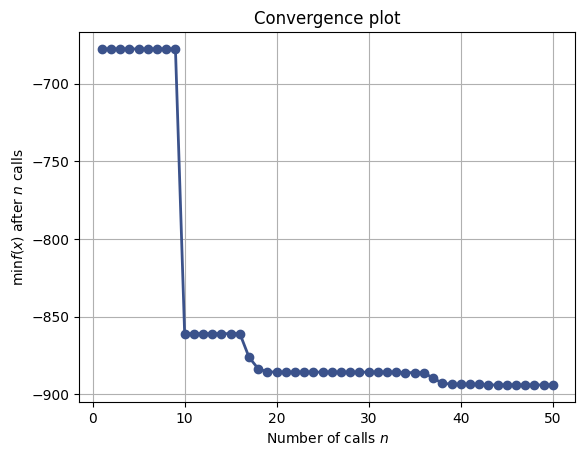

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import qmc
from skopt import gp_minimize
from skopt.space import Real
from skopt.utils import use_named_args

# Define the Eggholder function as the oracle
def eggholder_function(x, y):
    term1 = -(y + 47) * np.sin(np.sqrt(abs(x/2 + (y + 47))))
    term2 = -x * np.sin(np.sqrt(abs(x - (y + 47))))
    return term1 + term2

# Define the function to optimize (single input for skopt)
def objective(params):
    x, y = params
    return eggholder_function(x, y)

# Set up the space of parameters for Bayesian optimization
space = [Real(-512, 512, name='x'), Real(-512, 512, name='y')]

# Generate initial samples using LHS
lhs_sampler = qmc.LatinHypercube(d=2)
lhs_samples = lhs_sampler.random(n=5)
lhs_samples_scaled = qmc.scale(lhs_samples, [0, 0], [1, 1])  # Scaling to [0,1] range for skopt
initial_points = [(x[0]*1024 - 512, x[1]*1024 - 512) for x in lhs_samples_scaled]  # Rescale back to original range

# Perform Bayesian optimization
@use_named_args(space)
def objective_wrapped(**params):
    return objective([params['x'], params['y']])

result = gp_minimize(objective_wrapped, space, x0=initial_points, n_calls=50, random_state=1729)

# Extract the best result
best_x, best_y = result.x
best_fun = result.fun

print(f"Best point found: (x={best_x}, y={best_y}), Function value: {best_fun}")

# Optionally, we can plot the convergence of the optimization process
from skopt.plots import plot_convergence
plot_convergence(result)
plt.show()


1. Sample 5 points by using Latin hypercube sampling.
2. Use a machine learning model (learner) to learn from these 5 points.
3. Start the adaptive sampling loop. Inside this loop, generate 5 more samples near the optimal point of the learner by using LHS. Then go to Oracle as a batch of 5 samples. Check the real values (eggholder function values) of these 5 samples. Choose the point with the maximum variance between the real value and the sampled value.
4. Update the learner with the chosen point in step 3.
5. Stop until the performance metrics of the learner can't improve. (Or improvement is negligible.)

In [ ]:
import numpy as np
from scipy.stats import qmc
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Define the Eggholder function
def eggholder_function(x, y):
    term1 = -(y + 47) * np.sin(np.sqrt(abs(x / 2 + (y + 47))))
    term2 = -x * np.sin(np.sqrt(abs(x - (y + 47))))
    return term1 + term2

# Sample initial points using Latin hypercube sampling
lhs = qmc.LatinHypercube(d=2)
initial_samples = lhs.random(n=5)
lower_bounds = [-512, -512]
upper_bounds = [512, 512]
initial_points = qmc.scale(initial_samples, lower_bounds, upper_bounds)
initial_values = np.array([eggholder_function(x, y) for x, y in initial_points])

# Train the initial Gaussian Process model
kernel = Matern(nu=2.5)
gp = GaussianProcessRegressor(kernel=kernel, alpha=1e-5)
gp.fit(initial_points, initial_values)

# Adaptive sampling loop
tolerance = 1e-5  # Tolerance for improvement
previous_best = np.min(initial_values)
improvement = np.inf
max_iterations = 100
iteration = 0

while improvement > tolerance and iteration < max_iterations:
    iteration += 1
    # Generate more samples near the optimal point using LHS
    center = initial_points[np.argmin(initial_values)]
    new_samples = lhs.random(n=5)  # Generate new LHS samples
    # Scale the new samples to be around the current best estimate
    new_points = qmc.scale(new_samples, center - 0.05 * np.array([1024, 1024]), center + 0.05 * np.array([1024, 1024]))
    new_values = np.array([eggholder_function(x, y) for x, y in new_points])

    # Oracle provides the true values, we compute the variance
    preds, stds = gp.predict(new_points, return_std=True)
    discrepancies = (new_values - preds) ** 2

    # Select the point with the maximum variance
    max_discrepancy_idx = np.argmax(discrepancies)
    new_sample_point = new_points[max_discrepancy_idx, :]
    new_sample_value = new_values[max_discrepancy_idx]

    # Update the Gaussian Process model with the chosen point
    gp.fit(np.vstack([initial_points, new_sample_point]), np.append(initial_values, new_sample_value))

    # Check improvement
    current_best = np.min(np.append(initial_values, new_sample_value))
    improvement = previous_best - current_best
    previous_best = current_best

    # Update the data with the new sample
    initial_points = np.vstack([initial_points, new_sample_point])
    initial_values = np.append(initial_values, new_sample_value)

    print(f"Iteration {iteration}: Current best = {current_best}, Improvement = {improvement}")

print("Optimization has converged or maximum iterations reached.")


Iteration 1: Current best = -373.1812809531548, Improvement = 27.14091167776894
Iteration 2: Current best = -373.1812809531548, Improvement = 0.0
Optimization has converged or maximum iterations reached.


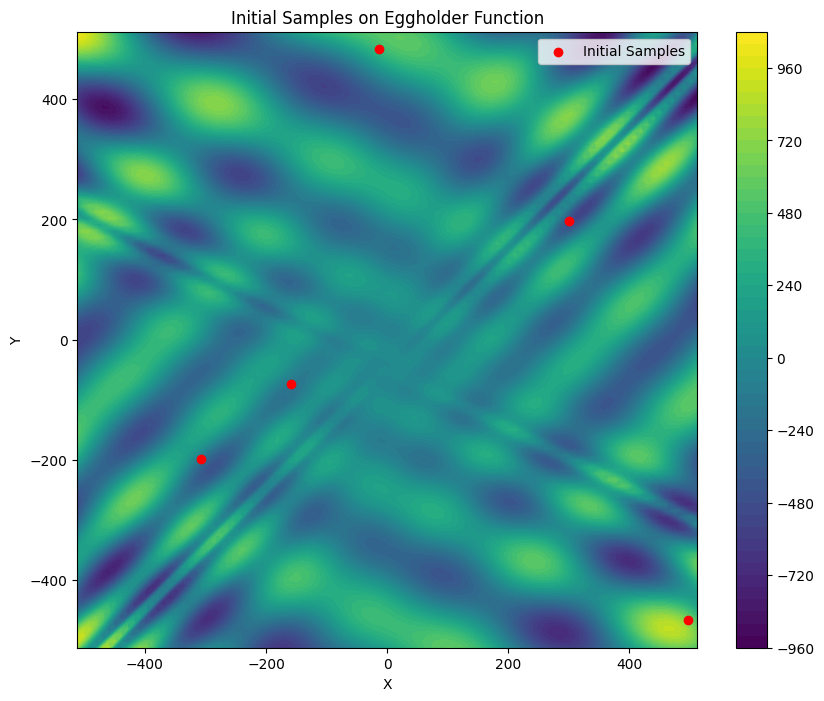

[[-500.20367679   11.90785846]]
Convergence reached at iteration 1.


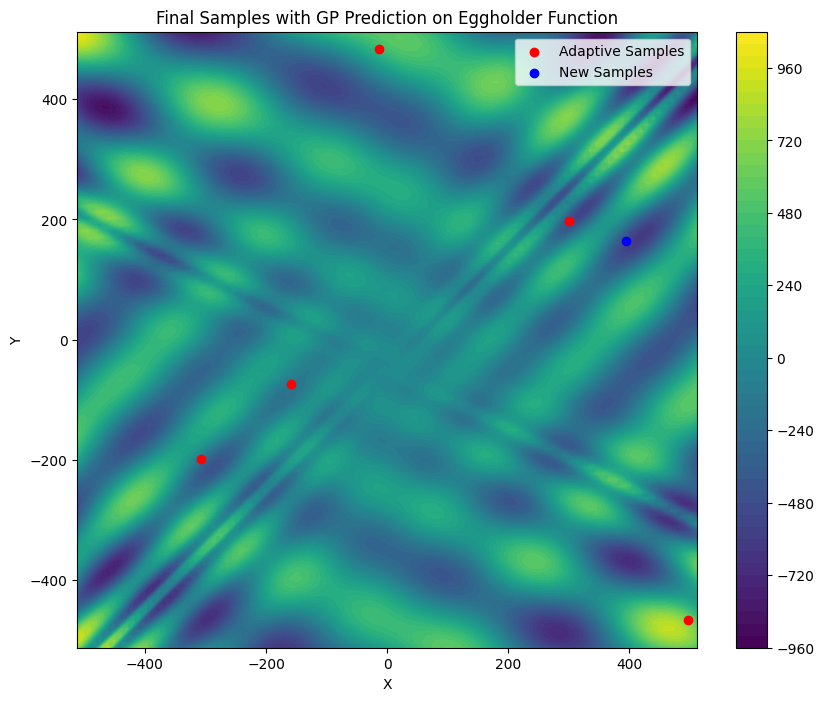

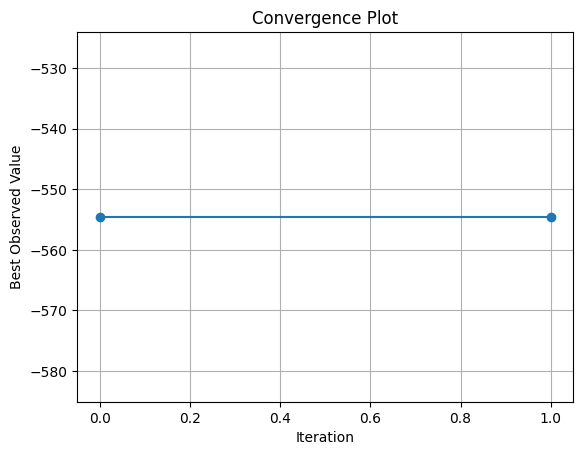

Best observed function value is -554.5591334959777


In [3]:
import numpy as np
from scipy.stats import qmc
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern
import matplotlib.pyplot as plt

# Define the Eggholder function
def eggholder_function(x, y):
    term1 = -(y + 47) * np.sin(np.sqrt(abs(x / 2 + (y + 47))))
    term2 = -x * np.sin(np.sqrt(abs(x - (y + 47))))
    return term1 + term2

# Generate a mesh for the background Eggholder function
x = np.linspace(-512, 512, 100)
y = np.linspace(-512, 512, 100)
X, Y = np.meshgrid(x, y)
Z = eggholder_function(X, Y)

# Sample initial points using Latin hypercube sampling
lhs = qmc.LatinHypercube(d=2)
initial_samples = lhs.random(n=5)
initial_points = qmc.scale(initial_samples, [-512, -512], [512, 512])
initial_values = np.array([eggholder_function(x, y) for x, y in initial_points])
initial_x = initial_points[:, 0]
initial_y = initial_points[:, 1]

# Train the initial Gaussian Process model
kernel = Matern(nu=2.5)
gp = GaussianProcessRegressor(kernel=kernel, alpha=1e-5, n_restarts_optimizer=5)
gp.fit(initial_points, initial_values)

# Plot initial samples
plt.figure(figsize=(10, 8))
plt.contourf(X, Y, Z, levels=50, cmap='viridis')
plt.colorbar()
plt.scatter(initial_x, initial_y, c='red', label='Initial Samples')
plt.legend()
plt.title('Initial Samples on Eggholder Function')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

# Start the active learning loop for optimization with adaptive sampling
num_iterations = 1000
tolerance = 1e-5
improvements = []  # Track improvement over iterations

# Perform active learning with adaptive sampling
new_samples = []
for iteration in range(num_iterations):
    # Get prediction and standard deviation for the whole domain
    mu, std = gp.predict(np.hstack((X.ravel()[:, np.newaxis], Y.ravel()[:, np.newaxis])), return_std=True)
    mu = mu.reshape(X.shape)
    std = std.reshape(X.shape)

    # Generate new candidate samples using LHS
    new_samples_lhs = lhs.random(n=5)
    new_points = qmc.scale(new_samples_lhs, [-512, -512], [512, 512])

    # Get true function values for new points and select the point with the largest discrepancy
    new_values = np.array([eggholder_function(x, y) for x, y in new_points])
    new_preds, new_stds = gp.predict(new_points, return_std=True)
    discrepancies = np.abs(new_values - new_preds)
    max_discrepancy_idx = np.argmax(discrepancies)

    # Update the model with the new point
    chosen_new_point = new_points[max_discrepancy_idx].reshape(1, -1)
    chosen_new_value = np.array([new_values[max_discrepancy_idx]])
    gp.fit(np.vstack([initial_points, chosen_new_point]), np.append(initial_values, chosen_new_value))

    # Track improvements and check for convergence
    current_best = np.min(np.append(initial_values, chosen_new_value))
    if improvements:
        improvement = improvements[-1] - current_best
    else:
        improvement = np.inf
    improvements.append(current_best)
    if improvement <= tolerance:
        print(f"Convergence reached at iteration {iteration}.")
        break

    # Add the new point to the initial samples
    initial_points = np.vstack([initial_points, chosen_new_point])
    initial_values = np.append(initial_values, chosen_new_value)

    print(chosen_new_point)


# Final plot with all samples and the Gaussian Process model prediction
plt.figure(figsize=(10, 8))
plt.contourf(X, Y, Z, levels=50, cmap='viridis')
plt.colorbar()
plt.scatter(initial_x, initial_y, c='red', label='Adaptive Samples')
plt.scatter(chosen_new_point[:,0], chosen_new_point[:,1], c='blue', label='New Samples')
plt.legend()
plt.title('Final Samples with GP Prediction on Eggholder Function')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

# Plot convergence over iterations
plt.figure()
plt.plot(range(len(improvements)), improvements, marker='o')
plt.title('Convergence Plot')
plt.xlabel('Iteration')
plt.ylabel('Best Observed Value')
plt.grid(True)
plt.show()

print(f"Best observed function value is {improvements[-1]}")

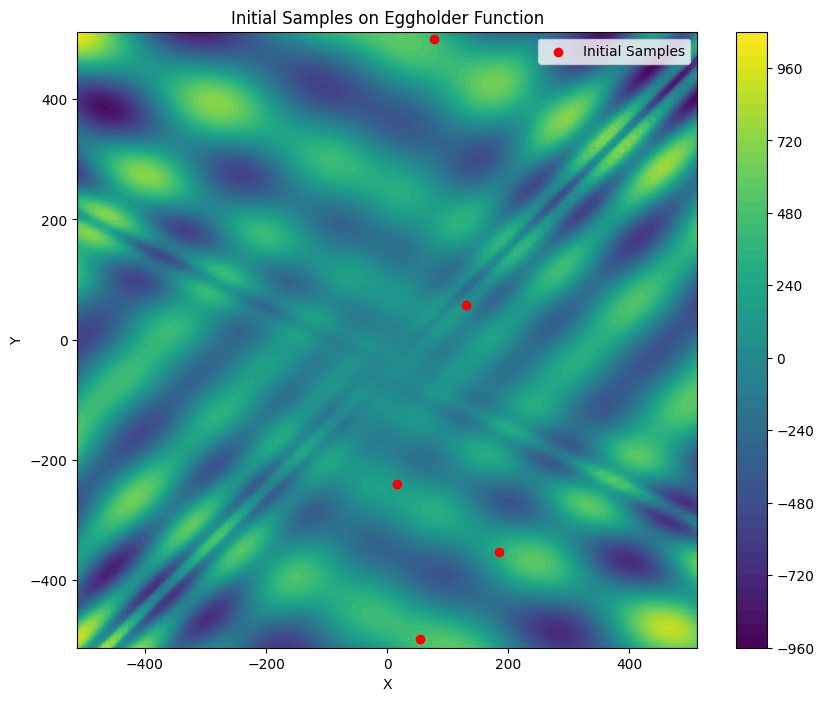

[[499.61984613 159.20209183]]
[[350.39461849 161.28854432]]
Convergence reached at iteration 2.


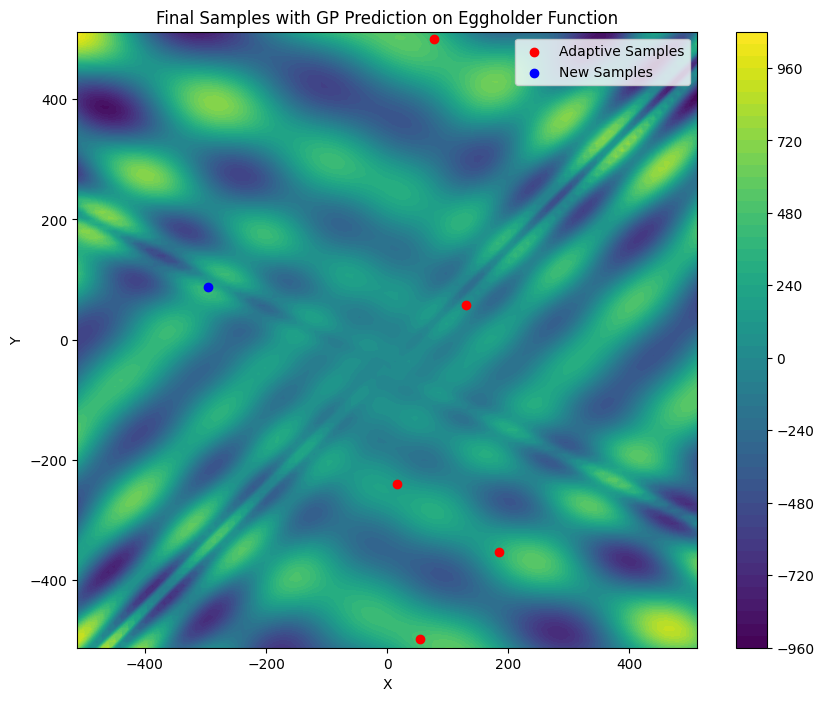

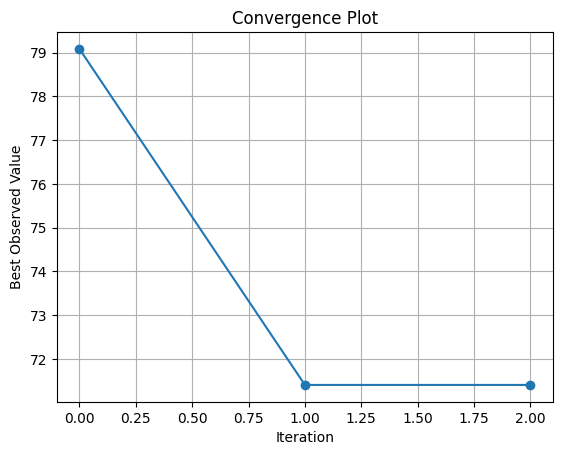

Best observed function value is 71.40608173048975


In [ ]:
import numpy as np
from scipy.stats import qmc
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern
import matplotlib.pyplot as plt

# Define the Eggholder function
def eggholder_function(x, y):
    term1 = -(y + 47) * np.sin(np.sqrt(abs(x / 2 + (y + 47))))
    term2 = -x * np.sin(np.sqrt(abs(x - (y + 47))))
    return term1 + term2

# Generate a mesh for the background Eggholder function
x = np.linspace(-512, 512, 100)
y = np.linspace(-512, 512, 100)
X, Y = np.meshgrid(x, y)
Z = eggholder_function(X, Y)

# Random sampling
n_samples = 5
d = 2  # Dimension
# Generate random samples in the range [0, 1]
random_samples = np.random.rand(n_samples, d)
# Scale samples to the desired range
initial_points = np.empty_like(random_samples)
initial_points[:, 0] = random_samples[:, 0] * (512 - (-512)) + (-512)
initial_points[:, 1] = random_samples[:, 1] * (512 - (-512)) + (-512)

# Calculate the function values at the sampled points
initial_values = np.array([eggholder_function(x, y) for x, y in initial_points])
initial_x = initial_points[:, 0]
initial_y = initial_points[:, 1]

# Train the initial Gaussian Process model
kernel = Matern(nu=2.5)
gp = GaussianProcessRegressor(kernel=kernel, alpha=1e-5, n_restarts_optimizer=5)
gp.fit(initial_points, initial_values)

# Plot initial samples
plt.figure(figsize=(10, 8))
plt.contourf(X, Y, Z, levels=50, cmap='viridis')
plt.colorbar()
plt.scatter(initial_x, initial_y, c='red', label='Initial Samples')
plt.legend()
plt.title('Initial Samples on Eggholder Function')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

# Start the active learning loop for optimization with adaptive sampling
num_iterations = 1000
tolerance = 1e-5
improvements = []  # Track improvement over iterations

# Perform active learning with adaptive sampling
new_samples = []
for iteration in range(num_iterations):
    # Get prediction and standard deviation for the whole domain
    mu, std = gp.predict(np.hstack((X.ravel()[:, np.newaxis], Y.ravel()[:, np.newaxis])), return_std=True)
    mu = mu.reshape(X.shape)
    std = std.reshape(X.shape)

    # Generate new candidate samples using LHS
    new_samples_lhs = lhs.random(n=5)
    new_points = qmc.scale(new_samples_lhs, [-512, -512], [512, 512])

    # Get true function values for new points and select the point with the largest discrepancy
    new_values = np.array([eggholder_function(x, y) for x, y in new_points])
    new_preds, new_stds = gp.predict(new_points, return_std=True)
    discrepancies = np.abs(new_values - new_preds)
    max_discrepancy_idx = np.argmax(discrepancies)

    # Update the model with the new point
    chosen_new_point = new_points[max_discrepancy_idx].reshape(1, -1)
    chosen_new_value = np.array([new_values[max_discrepancy_idx]])
    gp.fit(np.vstack([initial_points, chosen_new_point]), np.append(initial_values, chosen_new_value))

    # Track improvements and check for convergence
    current_best = np.min(np.append(initial_values, chosen_new_value))
    if improvements:
        improvement = improvements[-1] - current_best
    else:
        improvement = np.inf
    improvements.append(current_best)
    if improvement <= tolerance:
        print(f"Convergence reached at iteration {iteration}.")
        break

    # Add the new point to the initial samples
    initial_points = np.vstack([initial_points, chosen_new_point])
    initial_values = np.append(initial_values, chosen_new_value)

    print(chosen_new_point)


# Final plot with all samples and the Gaussian Process model prediction
plt.figure(figsize=(10, 8))
plt.contourf(X, Y, Z, levels=50, cmap='viridis')
plt.colorbar()
plt.scatter(initial_x, initial_y, c='red', label='Adaptive Samples')
plt.scatter(chosen_new_point[:,0], chosen_new_point[:,1], c='blue', label='New Samples')
plt.legend()
plt.title('Final Samples with GP Prediction on Eggholder Function')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

# Plot convergence over iterations
plt.figure()
plt.plot(range(len(improvements)), improvements, marker='o')
plt.title('Convergence Plot')
plt.xlabel('Iteration')
plt.ylabel('Best Observed Value')
plt.grid(True)
plt.show()

print(f"Best observed function value is {improvements[-1]}")

In [ ]:
import numpy as np
from scipy.stats import qmc
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern

# Define the Eggholder function
def eggholder_function(x, y):
    term1 = -(y + 47) * np.sin(np.sqrt(abs(x / 2 + (y + 47))))
    term2 = -x * np.sin(np.sqrt(abs(x - (y + 47))))
    return term1 + term2

# Sample initial points using Latin hypercube sampling
lhs = qmc.LatinHypercube(d=2)
initial_samples = lhs.random(n=5)
initial_points = qmc.scale(initial_samples, [-512, -512], [512, 512])
initial_values = np.array([eggholder_function(x, y) for x, y in initial_points])

# Train the initial Gaussian Process model
kernel = Matern(nu=2.5)
gp = GaussianProcessRegressor(kernel=kernel, alpha=1e-5, n_restarts_optimizer=5)
gp.fit(initial_points, initial_values)

# Perform adaptive sampling with batch updates
num_iters = 5  # Update the model with 5 batches
batch_size = 5  # Batch size of new points

for iter in range(num_iters):
    # Generate new candidate samples using LHS
    new_samples_lhs = lhs.random(n=batch_size)
    new_points = qmc.scale(new_samples_lhs, [-512, -512], [512, 512])

    # Get true function values for new points
    new_values = np.array([eggholder_function(x, y) for x, y in new_points])
    new_preds = gp.predict(new_points)

    # Calculate discrepancies and select the points with the largest discrepancies
    discrepancies = np.abs(new_values - new_preds)
    # Select batch points with maximum discrepancies
    batch_indices = np.argpartition(discrepancies, -batch_size)[-batch_size:]
    batch_points = new_points[batch_indices]
    batch_values = new_values[batch_indices]

    # Update the model with the new batch of points
    gp.fit(np.vstack((initial_points, batch_points)), np.hstack((initial_values, batch_values)))

    # Update initial points and values with new points
    initial_points = np.vstack((initial_points, batch_points))
    initial_values = np.hstack((initial_values, batch_values))

    print(f"Batch {iter + 1} added to the model.")

print("Active learning with batch updates complete.")


Batch 1 added to the model.
Batch 2 added to the model.
Batch 3 added to the model.
Batch 4 added to the model.
Batch 5 added to the model.
Active learning with batch updates complete.


## Mean squared error as convergence factor

Iteration 0, RMSE: 256.7080914516437
Iteration 1, RMSE: 191.94619693290792
Iteration 2, RMSE: 230.28762754566986
Iteration 3, RMSE: 158.940222045046
Iteration 4, RMSE: 263.28428562960426
Iteration 5, RMSE: 275.3817060802328
Iteration 6, RMSE: 181.54227633828717
Iteration 7, RMSE: 229.1290169703191
Iteration 8, RMSE: 165.53859907231583
Iteration 9, RMSE: 245.09200090303938
Iteration 10, RMSE: 279.39409885313177
Iteration 11, RMSE: 290.4306607568543
Iteration 12, RMSE: 241.37455032859887
Iteration 13, RMSE: 199.21429277362216
Iteration 14, RMSE: 270.3980523865397
Iteration 15, RMSE: 280.628651092659
Iteration 16, RMSE: 208.18450891206447
Convergence reached at iteration 17.


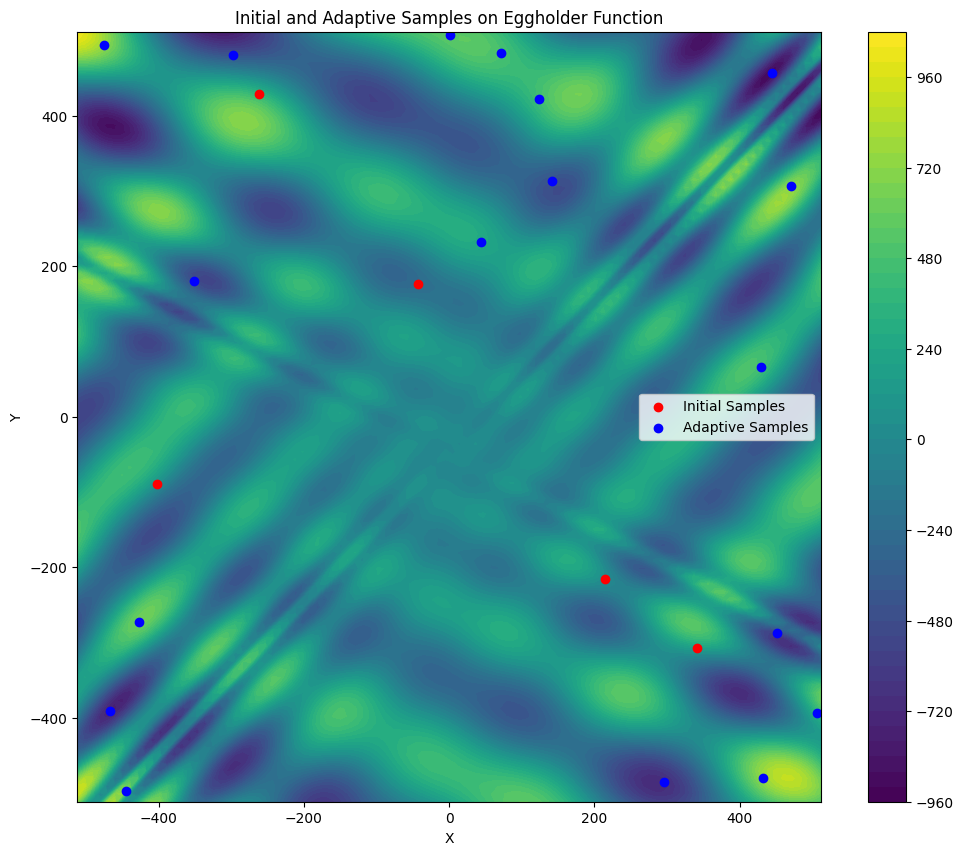

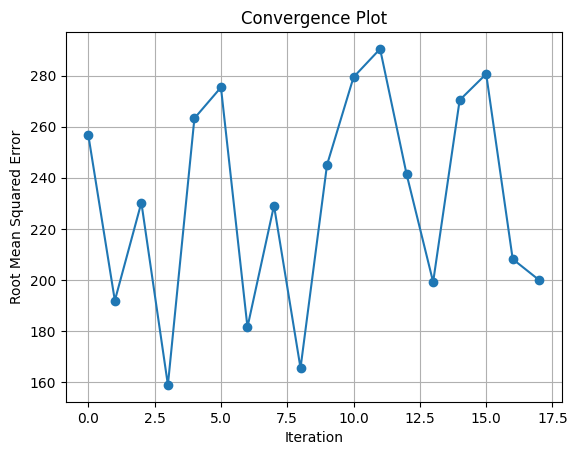

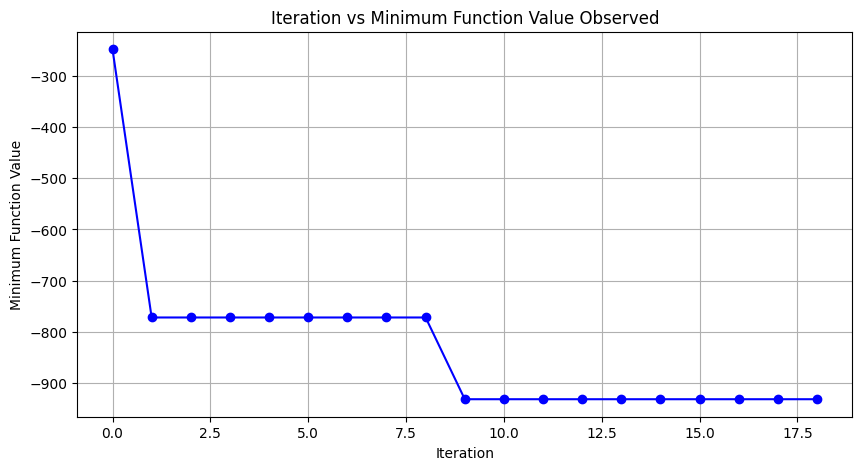

Best observed function value after active learning: -931.9326246416556


In [15]:
import numpy as np
from scipy.stats import qmc
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern
from sklearn.metrics import mean_squared_error

# Define the Eggholder function
def eggholder_function(x, y):
    term1 = -(y + 47) * np.sin(np.sqrt(abs(x / 2 + (y + 47))))
    term2 = -x * np.sin(np.sqrt(abs(x - (y + 47))))
    return term1 + term2

# Generate a mesh for the background Eggholder function
x = np.linspace(-512, 512, 100)
y = np.linspace(-512, 512, 100)
X, Y = np.meshgrid(x, y)
Z = eggholder_function(X, Y)

# Sample initial points using Latin hypercube sampling
lhs = qmc.LatinHypercube(d=2)
initial_samples = lhs.random(n=5)
initial_points = qmc.scale(initial_samples, [-512, -512], [512, 512])
initial_values = np.array([eggholder_function(x, y) for x, y in initial_points])

# Train the initial Gaussian Process model
kernel = Matern(nu=2.5)
gp = GaussianProcessRegressor(kernel=kernel, alpha=1e-5, n_restarts_optimizer=5)
gp.fit(initial_points, initial_values)

# Start the active learning loop for optimization with adaptive sampling
num_iterations = 1000
tolerance = 10
improvement = []  # Track improvement over iterations

# Perform active learning with adaptive sampling
new_points_all = initial_points.copy()
new_values_all = initial_values.copy()

min_function_values = [np.min(initial_values)]  # Track min function value for each iteration

for iteration in range(num_iterations):
    # Get prediction for the whole domain
    mu, std = gp.predict(np.hstack((X.ravel()[:, np.newaxis], Y.ravel()[:, np.newaxis])), return_std=True)
    mu = mu.reshape(X.shape)
    std = std.reshape(X.shape)

    # Generate new candidate samples using LHS
    new_samples_lhs = lhs.random(n=10)
    new_points = qmc.scale(new_samples_lhs, [-512, -512], [512, 512])

    # Get true function values for new points
    new_values = np.array([eggholder_function(x, y) for x, y in new_points])
    new_preds, new_stds = gp.predict(new_points, return_std=True)
    discrepancies = np.abs(new_values - new_preds)
    max_discrepancy_idx = np.argmax(discrepancies)

    # Update the model with the new point
    chosen_new_point = new_points[max_discrepancy_idx].reshape(1, -1)
    chosen_new_value = np.array([new_values[max_discrepancy_idx]])

    # Update training data
    new_points_all = np.vstack([new_points_all, chosen_new_point])
    new_values_all = np.append(new_values_all, chosen_new_value)

    # Keep track of the minimum function value observed so far
    min_function_values.append(np.min(np.hstack((gp.y_train_, new_values))))

    # Re-fit the model including the new points
    gp.fit(new_points_all, new_values_all)

    # Calculate improvement
    rmse = (mean_squared_error(new_values, gp.predict(new_points)))**0.5
    improvement.append(rmse)

    # Check for convergence
    if len(improvement) > 1 and abs(improvement[-2] - improvement[-1]) <= tolerance:
        print(f"Convergence reached at iteration {iteration}.")
        break

    print(f"Iteration {iteration}, RMSE: {rmse}")

# Plot initial and final samples
plt.figure(figsize=(12, 10))
plt.contourf(X, Y, Z, levels=50, cmap='viridis')
plt.colorbar()
plt.scatter(initial_points[:, 0], initial_points[:, 1], c='red', label='Initial Samples')
plt.scatter(new_points_all[5:, 0], new_points_all[5:, 1], c='blue', label='Adaptive Samples')
plt.legend()
plt.title('Initial and Adaptive Samples on Eggholder Function')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

# Plot convergence over iterations
plt.figure()
plt.plot(range(len(improvement)), improvement, marker='o')
plt.title('Convergence Plot')
plt.xlabel('Iteration')
plt.ylabel('Root Mean Squared Error')
plt.grid(True)
plt.show()

# Plot iteration vs minimum function values observed
plt.figure(figsize=(10, 5))
plt.plot(min_function_values, marker='o', linestyle='-', color='blue')
plt.title('Iteration vs Minimum Function Value Observed')
plt.xlabel('Iteration')
plt.ylabel('Minimum Function Value')
plt.grid(True)
plt.show()


# Print final result
print(f"Best observed function value after active learning: {np.min(new_values_all)}")

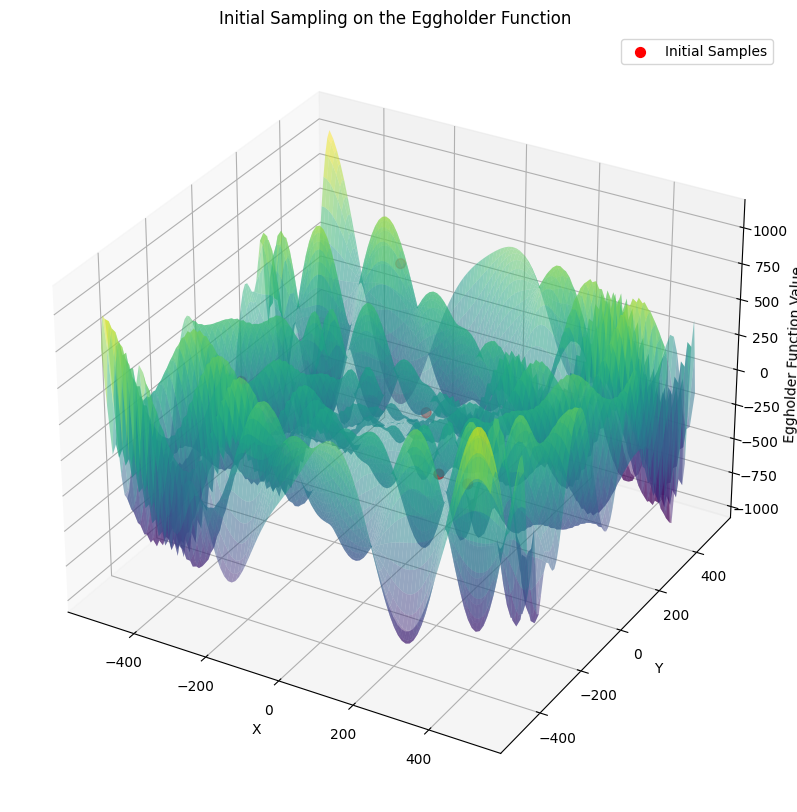

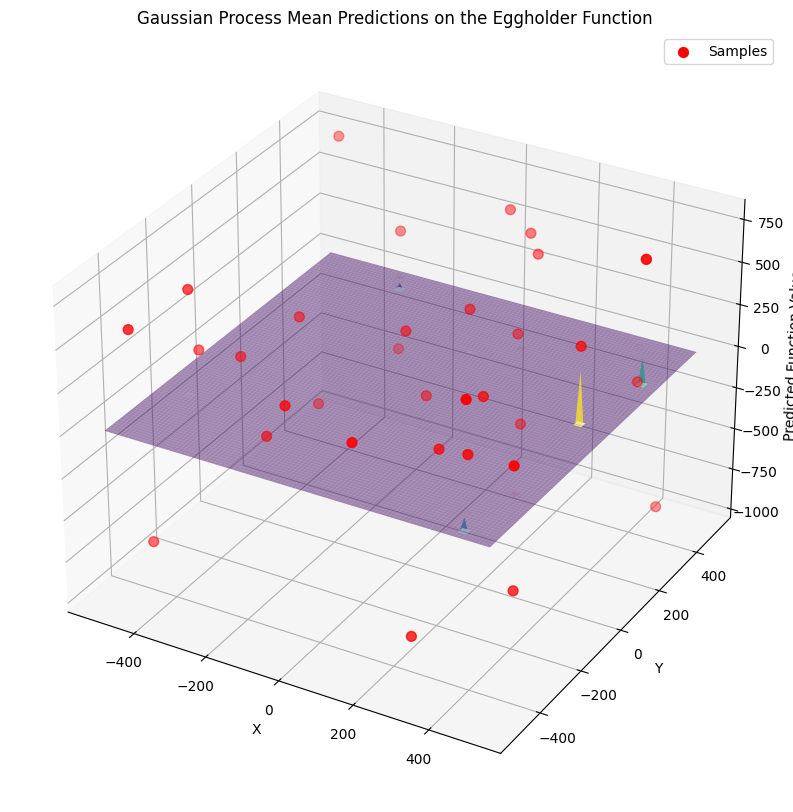

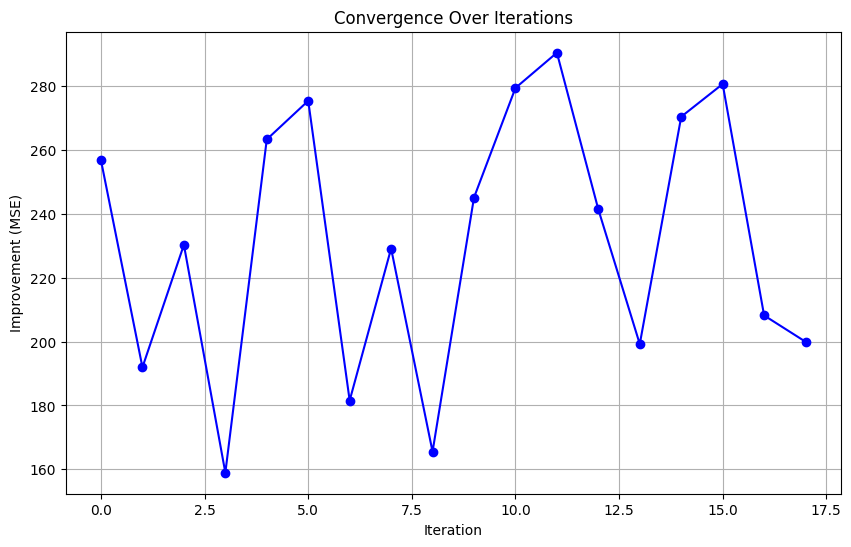

In [16]:
# Create mesh grid for plotting
x = np.linspace(-512, 512, 100)
y = np.linspace(-512, 512, 100)
X, Y = np.meshgrid(np.linspace(-512, 512, 100), np.linspace(-512, 512, 100))
Z = eggholder_function(X.ravel(), Y.ravel()).reshape(X.shape)

# Plot the function surface
plt.figure(figsize=(14, 10))
ax = plt.axes(projection='3d')
ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap='viridis', edgecolor='none', alpha=0.5)
ax.scatter(initial_points[:, 0], initial_points[:, 1], initial_values, color='r', s=50, label='Initial Samples')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Eggholder Function Value')
ax.set_title('Initial Sampling on the Eggholder Function')
ax.legend()
plt.show()

# Update the Gaussian Process model with the new batch of points
gp.fit(np.vstack([gp.X_train_, new_points]), np.hstack([gp.y_train_, new_values]))

# Predict over the entire grid
mu, std = gp.predict(np.hstack((X.ravel()[:, np.newaxis], Y.ravel()[:, np.newaxis])), return_std=True)
mu = mu.reshape(X.shape)
std = std.reshape(X.shape)

# Plot the mean predictions and uncertainty
plt.figure(figsize=(14, 10))
ax = plt.axes(projection='3d')
ax.plot_surface(X, Y, mu, rstride=1, cstride=1, cmap='viridis', edgecolor='none', alpha=0.5)
ax.scatter(gp.X_train_[:, 0], gp.X_train_[:, 1], gp.y_train_, color='r', s=50, label='Samples')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Predicted Function Value')
ax.set_title('Gaussian Process Mean Predictions on the Eggholder Function')
ax.legend()
plt.show()

# Plot the convergence graph
plt.figure(figsize=(10, 6))
plt.plot(improvement, marker='o', linestyle='-', color='b')
plt.xlabel('Iteration')
plt.ylabel('Improvement (MSE)')
plt.title('Convergence Over Iterations')
plt.grid(True)
plt.show()
